In [78]:
import numpy as np
import matplotlib.pyplot as plt
import time
from numba import jit,njit
from scipy.integrate import solve_ivp
from numba.typed import List
exp=np.exp

@jit
def alpha_m (V):
    return -0.025*(V+40.)/( exp(-(V+40)/10) - 1.0 )
@jit
def beta_m(V):
    return exp(-(V+65)/18)
@jit
def mNa_inf(V):
    return alpha_m(V) / (alpha_m(V) + beta_m(V))
@jit
def tau_mNa(V):
    return 1 / (alpha_m(V) + beta_m(V))/5
@jit
def alpha_h(V):
    return 0.0175*exp(-(V+65)/20)
@jit
def beta_h(V):
    return 0.25/(1.0 + exp(-(V+35)/10) )
@jit
def hNa_inf(V):
    return alpha_h(V) / (alpha_h(V) + beta_h(V))
@jit
def tau_hNa (V):
    return 1 / (alpha_h(V) + beta_h(V))/5
Kdshift=10.0
@jit
def alpha_mKd(V):
    return 0.0025*(V+55.)/(1. - exp(-(V+55.)/10.))

@jit
def beta_mKd(V):
    return 0.03125*exp(-(V+65.)/80.)

@jit
def mKd_inf (V):
    return alpha_mKd(V-Kdshift) / (alpha_mKd(V-Kdshift) + beta_mKd(V-Kdshift))
@jit
def tau_mKd (V):
    return 1 / (alpha_mKd(V-Kdshift) + beta_mKd(V-Kdshift))/5 

@jit
def mA_inf (V):
    return 1/(1+exp(-(V+90)/8.5))
@jit
def tau_mA (V):
    return 0.37 + 1/(exp((V+35.82)/19.697)+exp((V+79.69)/-12.7))/5
@jit
def hA_inf (V):
    return 1/(1+exp((V+78)/6))

@jit
def tau_hA(V): # Inactivation time-constant
    if (V < -63):
        tau_hA = 1/(exp((V+46.05)/5)+exp((V+238.4)/-37.45))
    else:
        tau_hA = 19
    return tau_hA/5

@jit
def mKir_inf (V):
    return 1/(1+exp((V+97.9+10)/9.7))

# T-type Ca-current (mt=activation variable, ht=inactivation variable)
@jit
def mt_inf (V):
    return 1/(1+exp(-(V+57)/6.2)) # Activation function
@jit
def tau_mt (V):
    return 0.612 + 1/(exp(-(V+131.6)/16.7)+exp((V+16.8)/18.2)) # Activation time-constant
@jit
def ht_inf(V):
    return 1/(1+exp((V+81)/4.03))# Inactivation function
@jit
def tau_ht(V): # Inactivation time-constant
    if (V < -80):
        tau_ht = exp((V+467)/66.6)
    else:
        tau_ht = (exp(-(V+21.88)/10.2)+28)
    return tau_ht


# L-type Ca-current (mL=activation variable)
@jit
def mL_inf (V):
    return 1/(1+exp(-(V+55.)/3)) # Activation function
@jit
def tau_mL(V):
    return (72*exp(-(V+45.)**2/400)+6.)# Activation time-constant

# H-current (mH=activation variable)
@jit
def alpha_mH (V):
    return exp(-14.59-(0.086*V))
@jit
def beta_mH (V):
    return exp(-1.87+(0.0701*V))
@jit
def mH_inf (V):
    return  alpha_mH(V) /(alpha_mH(V) + beta_mH(V)) # Activation function
@jit 
def tau_mH (V):
    return 1/(alpha_mH(V) + beta_mH(V)) # Activation time-constant
@jit 
def heaviside (t):
    return (1+np.sign(t))/2
@jit 
def pulse (t,ti,tf):
    return heaviside(t-ti)-heaviside(t-tf)

sin=np.sin
pi=np.pi

@jit 
def Syn_sigm(V):
    rSyn = -45;
    kSyn = 2;
    return 1/(1+exp(-(V-rSyn)/kSyn))
@jit 
def Syn_inf(V,a,b):
    return a*Syn_sigm(V)/(a*Syn_sigm(V)+b)
 
@jit 
def max_abs(a,b):
    if abs(a)>abs(b):
        return a
    else:
        return b
    



In [79]:
@jit
def HM_ODE_element(t,u,p,V_pre):
    # Parameters
    min_num=1e-60
    Iapp=p[0] # Amplitude of constant applied current
    I1=p[1] # Amplitude of first step input
    I2=p[2] # Amplitude of second step input
    ti1=p[3] # Starting time of first step input
    tf1=p[4] # Ending time of first step input
    ti2=p[5] # Starting time of second step input
    tf2=p[6] # Ending time of second step input
    gT=p[7] # T-type calcium current maximal conductance
    gKd=p[8]  # Delayed-rectifier potassium current maximal conductance
    gH=p[9] # H-current maximal conductance
    gNa=p[10] # Sodium current maximal conductance
    gA=p[11] # A-type potassium current maximal conductance
    gKir=p[12]  # Inward-rectifier potassium current maximal conductance
    gLeak=p[13] # Leak current maximal conductance
    gL=p[14] # L-type calcium current maximal conductance
    gKCa=p[15] # Calcium-activated potassium current maximal conductance
    gSyn=p[16:20] #synaptic conductance
    a=p[20]
    b=p[21]
    C=p[22] # Membrane capacitance
    taunoise=p[24] # Cutoff frequency for low-pass filtered Gaussian noise
    Ain=p[25] # Amplitude of sinusoïdal inut
    Win=p[26] # Frequency of  sinusoïdal inut

    # Variables
    V=u[0] # Membrane potential
    mNa=u[1] # Sodium current activation
    hNa=u[2] # Sodium current inactivation
    mH=u[3] # H current activation
    mt=u[4] # T-type calcium current activation
    ht=u[5] # T-type calcium current inactivation
    mA=u[6] # A-type potassium current activation
    hA=u[7] # A-type potassium current inactivation
    mKd=u[8] # Delayed-rectifier potassium current activation
    mL=u[9] # L-type calcium current activation
    Ca=u[10] # Intracellular calcium concentration
    mSyn = u[11:15] # synapse
    noise=u[15] # Input noise
    

    # ODEs
    du1=1/C*(- gNa*mNa**3*hNa*(V-VNa) - gH*mH*(V-VH) - gT*mt**2*ht*(V-VCa) - gA*mA**4*hA*(V-VK) - gKd*mKd**4*(V-VK) -
                gKir*mKir_inf(V)*(V-VK) - gLeak*(V-Vleak)- gL*mL*(V-VCa) - gKCa*(Ca/(15.0+Ca))**4*(V-VK) -
                gSyn[0]*mSyn[0]*(V-VSyn) - gSyn[1]*mSyn[1]*(V-VSyn) - gSyn[2]*mSyn[2]*(V-VSyn)-gSyn[3]*mSyn[3]*(V-VSyn)
             + Iapp + I1*pulse(t,ti1,tf1) + I2*pulse(t,ti2,tf2) + noise + Ain*sin(2*pi*Win*t)) # Voltage equation
    
    du2=1/max_abs(tau_mNa(V),min_num)*(-mNa+mNa_inf(V)) # gating equation
    du3=1/max_abs(tau_hNa(V),min_num)*(-hNa+hNa_inf(V))
    du4=1/max_abs(tau_mH(V),min_num)*(-mH+mH_inf(V))
    du5=1/max_abs(tau_mt(V),min_num)*(-mt+mt_inf(V))
    du6=1/max_abs(tau_ht(V),min_num)*(-ht+ht_inf(V))
    du7=1/max_abs(tau_mA(V),min_num)*(-mA+mA_inf(V))
    du8=1/max_abs(tau_hA(V),min_num)*(-hA+hA_inf(V))
    du9=1/max_abs(tau_mKd(V),min_num)*(-mKd+mKd_inf(V))
    du10=1/max_abs(tau_mL(V),min_num)*(-mL+mL_inf(V))
    du11=(-0.1*(gL*mL*(V-VCa))-0.01*Ca)/4 # Variation of intracellular calcium concentration
    du12=a*Syn_sigm(V_pre[0])*(1-mSyn[0])-b*mSyn[0]
    du13=a*Syn_sigm(V_pre[1])*(1-mSyn[1])-b*mSyn[1]
    du14=a*Syn_sigm(V_pre[2])*(1-mSyn[2])-b*mSyn[2]
    du15=a*Syn_sigm(V_pre[3])*(1-mSyn[3])-b*mSyn[3]
    du16=-noise/taunoise # Noise equation
    
    return [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14,du15,du16]

In [127]:

def  OB_ODE_element(t,u,p,V_pre):
    
    min_num=1e-60
    #it=iter(u)
    #dinamics,Theta,phi,P,u_sys=[[next(it) for _ in range(size)] for size in variable_size]
    
    V,mNa,hNa,mH,mt,ht,mA,hA,mKd,mL,Ca,mSyn_1,mSyn_2,mSyn_3,mSyn_4,noise=u[0:pos_dinamics]
    
    mSyn=[mSyn_1,mSyn_2,mSyn_3,mSyn_4]
    
    u_sys=u[pos_p:pos_u_sys]
    P=u[pos_phi:pos_p].reshape(num_phi,num_phi)
    Theta=u[pos_dinamics:pos_Theta]
    #print(Theta)
    phi=u[pos_Theta:pos_phi]
    
    obesV=u_sys[0]
    
    
    Iapp=p[0] # Amplitude of constant applied current
    I1=p[1] # Amplitude of first step input
    I2=p[2] # Amplitude of second step input
    ti1=p[3] # Starting time of first step input
    tf1=p[4] # Ending time of first step input
    ti2=p[5] # Starting time of second step input
    tf2=p[6] # Ending time of second step input
    gT=p[7] # T-type calcium current maximal conductance
    gKd=p[8]  # Delayed-rectifier potassium current maximal conductance
    gH=p[9] # H-current maximal conductance
    gNa=p[10] # Sodium current maximal conductance
    gA=p[11] # A-type potassium current maximal conductance
    gKir=p[12]  # Inward-rectifier potassium current maximal conductance
    gLeak=p[13] # Leak current maximal conductance
    gL=p[14] # L-type calcium current maximal conductance
    gKCa=p[15] # Calcium-activated potassium current maximal conductance
    gSyn=p[16:20] #synaptic conductance
    a=p[20]
    b=p[21]
    C=p[22] # Membrane capacitance
    taunoise=p[24] # Cutoff frequency for low-pass filtered Gaussian noise
    Ain=p[25] # Amplitude of sinusoïdal inut
    Win=p[26] # Frequency of  sinusoïdal inut

    
    
    PHI0= -mNa**3*hNa*(obesV-VNa) 
    PHI1= -mH*(obesV-VH)
    PHI2= -mt**2*ht*(obesV-VCa)
    PHI3= -mA**4*hA*(obesV-VK)
    PHI4= - mKd**4*(obesV-VK)
    PHI5= -mKir_inf(obesV)*(obesV-VK)
    PHI6= -(obesV-Vleak)
    PHI7= -mL*(obesV-VCa)
    PHI8= -(Ca/(15.0+Ca))**4*(obesV-VK)
    PHI9= -mSyn[0]*(obesV-VSyn)
    PHI10= -mSyn[1]*(obesV-VSyn)
    PHI11= -mSyn[2]*(obesV-VSyn)
    PHI12= -mSyn[3]*(obesV-VSyn)
    Current_in= Iapp + I1*pulse(t,ti1,tf1) + I2*pulse(t,ti2,tf2)+ Ain*sin(2*pi*Win*t)
    
    
    PHI= np.array([PHI0,PHI1,PHI2,PHI3,PHI4,PHI5,PHI6,PHI7,PHI8,PHI9,PHI10,PHI11,PHI12])
    
    #ODEs
    temp=gamma*(obesV-V)+gamma*np.dot(np.dot(phi,P),phi)*(obesV-V)# Voltage equation
    temp2=1/C*(np.dot(PHI,Theta) + Current_in)
    du1=temp+temp2
    #####
    du2=1/max_abs(tau_mNa(obesV),min_num)*(-mNa+mNa_inf(obesV)) # gating equation
    du3=1/max_abs(tau_hNa(obesV),min_num)*(-hNa+hNa_inf(obesV))
    du4=1/max_abs(tau_mH(obesV),min_num)*(-mH+mH_inf(obesV))
    du5=1/max_abs(tau_mt(obesV),min_num)*(-mt+mt_inf(obesV))
    du6=1/max_abs(tau_ht(obesV),min_num)*(-ht+ht_inf(obesV))
    du7=1/max_abs(tau_mA(obesV),min_num)*(-mA+mA_inf(obesV))
    du8=1/max_abs(tau_hA(obesV),min_num)*(-hA+hA_inf(obesV))
    du9=1/max_abs(tau_mKd(obesV),min_num)*(-mKd+mKd_inf(obesV))
    du10=1/max_abs(tau_mL(obesV),min_num)*(-mL+mL_inf(obesV))
    du11=(-0.1*(gL*mL*(obesV-VCa))-0.01*Ca)/4 # Variation of intracellular calcium concentration
    du12=a*Syn_sigm(V_pre[0])*(1-mSyn[0])-b*mSyn[0]
    du13=a*Syn_sigm(V_pre[1])*(1-mSyn[1])-b*mSyn[1]
    du14=a*Syn_sigm(V_pre[2])*(1-mSyn[2])-b*mSyn[2]
    du15=a*Syn_sigm(V_pre[3])*(1-mSyn[3])-b*mSyn[3]
    du16=-noise/taunoise # Noise equation
    
    du17=gamma_mask*np.dot(P,phi)*(obesV-V)
    
    du18=mask*(-gamma*phi+PHI)
    #du14=(np.absolute(du14)>min_num)*du14
    
    du19=alpha*P-np.dot(np.dot(P,np.outer(phi,phi)),P)
    
    du20=HM_ODE_element(t,u_sys,p,V_pre)
    
    
    return [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14,du15,du16], du17 ,du18,du19.flatten(),du20



In [128]:
def OB_ODE(t,u):
    return OB_ODE2_element(t,u,p,0)

In [129]:
@jit
def HM_ODE(t,u):
    return HM_ODE_element(t,u,p,0)

In [130]:
def HCO(t,u):
    v_pre1=List()
    [v_pre1.append(x) for x in [u[num_u_sys],0.,0.,0.]]
    neuron1= HM_ODE_element(t,np.array(u[0:num_u_sys]),p1,v_pre1)
    v_pre2=List()
    [v_pre2.append(x) for x in [u[0],0.,0.,0.]]
    neuron2= HM_ODE_element(t,np.array(u[num_u_sys:]),p2,v_pre2)
    return [*neuron1,*neuron2]

In [131]:
def three_neurons(t,u):
    neuron1= HM_ODE_element(t,u[:13],p1,u[13])
    neuron2= HM_ODE_element(t,u[13:26],p2,u[26])
    neuron3= HM_ODE_element(t,u[26:],p3,u[0])
    return neuron1+neuron2+neuron3

In [132]:
def three_neurons_OB(t,u):
#     a,b,c,d,e= OB_ODE_element(t,np.array(u[:num_parameter]),p1,u[num_parameter+pos_p])
#     neuron1=[*a,*b,*c,*d,*e]
#     a,b,c,d,e= OB_ODE_element(t,np.array(u[num_parameter:num_parameter*2]),p2,u[num_parameter*2+pos_p])
#     neuron2=[*a,*b,*c,*d,*e]
#     a,b,c,d,e= OB_ODE_element(t,np.array(u[num_parameter*2:]),p2,u[pos_p])
#     neuron3=[*a,*b,*c,*d,*e]
    v_pre1=List()
    [v_pre1.append(x) for x in [u[num_parameter+pos_p],u[num_parameter*2+pos_p],u[pos_p],0.]]
    a,b,c,d,e= OB_ODE_element(t,np.array(u[:num_parameter]),p1,v_pre1)
    neuron1=[*a,*b,*c,*d,*e]
    v_pre2=List()
    [v_pre2.append(x) for x in [u[num_parameter*2+pos_p],u[pos_p],u[num_parameter+pos_p],0.]]
    a,b,c,d,e= OB_ODE_element(t,np.array(u[num_parameter:num_parameter*2]),p2,v_pre2)
    neuron2=[*a,*b,*c,*d,*e]
    v_pre3=List()
    [v_pre3.append(x) for x in [u[pos_p],u[num_parameter+pos_p],u[num_parameter*2+pos_p],0.]]
    a,b,c,d,e= OB_ODE_element(t,np.array(u[num_parameter*2:]),p3,v_pre3)
    neuron3=[*a,*b,*c,*d,*e]
    return [*neuron1,*neuron2,*neuron3]

In [133]:
def five_neurons_OB(t,u):
    v_pre1=List()
    [v_pre1.append(x) for x in [u[num_parameter+pos_p],u[num_parameter*2+pos_p],u[num_parameter*3+pos_p],u[num_parameter*4+pos_p]]]
    a,b,c,d,e= OB_ODE_element(t,np.array(u[:num_parameter]),p1,v_pre1)
    neuron1=[*a,*b,*c,*d,*e]
    v_pre2=List()
    [v_pre2.append(x) for x in [u[num_parameter*2+pos_p],u[num_parameter*3+pos_p],u[pos_p],u[num_parameter*4+pos_p]]]
    a,b,c,d,e= OB_ODE_element(t,np.array(u[num_parameter:]),p2,v_pre2)
    neuron2=[*a,*b,*c,*d,*e]
    v_pre3=List()
    [v_pre3.append(x) for x in [u[num_parameter*3+pos_p],u[pos_p],u[num_parameter+pos_p],u[num_parameter*4+pos_p]]]
    a,b,c,d,e= OB_ODE_element(t,np.array(u[num_parameter*2:]),p3,v_pre3)
    neuron3=[*a,*b,*c,*d,*e]
    
    v_pre4=List()
    [v_pre4.append(x) for x in [u[num_parameter*4+pos_p],u[num_parameter+pos_p],u[num_parameter*2+pos_p],u[pos_p]]]
    a,b,c,d,e= OB_ODE_element(t,np.array(u[num_parameter*2:]),p4,v_pre4)
    neuron4=[*a,*b,*c,*d,*e]
    
    v_pre5=List()
    [v_pre5.append(x) for x in [u[pos_p],u[num_parameter+pos_p],u[num_parameter*2+pos_p],u[num_parameter*3+pos_p],]]
    a,b,c,d,e= OB_ODE_element(t,np.array(u[num_parameter*2:]),p5,v_pre5)
    neuron5=[*a,*b,*c,*d,*e]
    
    return [*neuron1,*neuron2,*neuron3,*neuron4,*neuron5]

In [87]:
def four_neurons(t,u):
    neuron1= HM_ODE_element(t,u[:13],p1,u[13])
    neuron2= HM_ODE_element(t,u[13:26],p2,u[26])
    neuron3= HM_ODE_element(t,u[26:39],p3,u[39])
    neuron4= HM_ODE_element(t,u[39:],p4,u[0])
    return neuron1+neuron2+neuron3+neuron4

In [88]:
def five_neurons(t,u):
    neuron1= HM_ODE_element(t,u[:13],p1,u[13])
    neuron2= HM_ODE_element(t,u[13:26],p2,u[26])
    neuron3= HM_ODE_element(t,u[26:39],p3,u[39])
    neuron4= HM_ODE_element(t,u[39:52],p4,u[52])
    neuron5= HM_ODE_element(t,u[52:],p5,u[0])
    return neuron1+neuron2+neuron3+neuron4+neuron5

In [102]:
def HCO_OB(t,u):
    v_pre1=List()
    [v_pre1.append(x) for x in [u[num_parameter+pos_p],0.,u[num_dinamics+num_Theta+num_phi+num_p],2.]]
    a,b,c,d,e= OB_ODE_element(t,np.array(u[:num_parameter]),p1,v_pre1)
    neuron1=[*a,*b,*c,*d,*e]
    v_pre2=List()
    [v_pre2.append(x) for x in [u[pos_p],0.,u[num_parameter+num_dinamics+num_Theta+num_phi+num_p],2.]]
    a,b,c,d,e= OB_ODE_element(t,np.array(u[num_parameter:]),p2,v_pre2)
    neuron2=[*a,*b,*c,*d,*e]
    return [*neuron1,*neuron2]

In [90]:
num_dinamics=13+3
num_Theta=13
num_phi=num_Theta
num_p=num_Theta**2
num_u_sys=13+3
num_parameter=num_dinamics+num_Theta+num_phi+num_p+num_u_sys
model_output=num_dinamics+num_Theta+num_phi+num_p+1
variable_size=[num_dinamics,num_Theta,num_phi,num_p,num_u_sys]

pos_dinamics=num_dinamics
pos_Theta=pos_dinamics+num_Theta
pos_phi=pos_Theta+num_phi
pos_p=pos_phi+num_p
pos_u_sys=pos_p+num_u_sys

In [91]:
#Test real model
## Simulation of the model in current-clamp mode

## Definition of reversal potential values. 
VNa = 50.; # Sodium reversal potential 45
VCa = 120.; # Calcium reversal potential
VK = -80.; # Potassium reversal potential -90
VH= -43.; # Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
Vleak = -49.; # Reversal potential of leak channels
VSyn=-120.

## Definition of membrane capacitance and maximal conductance values. 
C=0.1; # Membrane capacitance
gLeak=0.1; # Leak current maximal conductance
gNa=120.; # Sodium current maximal conductance
gKd=30.; # Delayed-rectifier potassium current maximal conductance
gA=0.; # A-type potassium current maximal conductance
gKir=0.; # Inward-rectifier potassium current maximal conductance
gT=2.; # T-type calcium current maximal conductance
gH=0.1; # H-current maximal conductance
gL=0.4; # L-type calcium current maximal conductance
gKCa=2.; # Calcium-activated potassium current maximal conductance
gSyn=4.0
a=2.0
b=0.1
## Definition of simulation time.
Tfinal=6000.0
tspan=[0.0,Tfinal]

## Input current defition
# Constant current
Iapp=-4.0

# Current pulses
I1=0. # Amplitude of first pulse
ti1=0. # Starting time of first pulse
tf1=100.0 # Ending time of first pulse
I2=0. # Amplitude of second pulse
ti2=50.0 # Starting time of second pulse
tf2=150.0 # Ending time of first pulse

# Sinusoidal input
Ain=0.0 # Amplitude
Win=0.5 # Frequency

# Input noise
NoiseIN=0.0 # Amplitude
TauNoise=2.0 # Cut-off frequency

## Current-clamp experiment
# Parameter vector for simulations
p=[Iapp,2.5,I2,ti1,tf1,ti2,tf2,gT,gKd,gH,gNa,gA,gKir,gLeak,gL,gKCa,gSyn,0,0,0,a,b,C,NoiseIN,TauNoise,Ain,Win]
p1 = List()
[p1.append(x) for x in p]
p=[Iapp,I1,I2,ti1,tf1,ti2,tf2,gT,gKd,gH,gNa,gA,gKir,gLeak,gL,gKCa,gSyn,0,0,0,a,b,C,NoiseIN,TauNoise,Ain,Win]
p2 = List()
[p2.append(x) for x in p]
# Initial conditions
V0= -70.
x0 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), 
      mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), Syn_inf(V0,a,b),0.,0.,0., 0.0]
V0= -63.
x1 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0),
      mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), Syn_inf(V0,a,b),0.,0.,0., 0.0]
X0= [*x0,*x1]


In [92]:
start = time.time()
sol=solve_ivp(HCO ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

Elapsed (with compilation) = 73.02046918869019


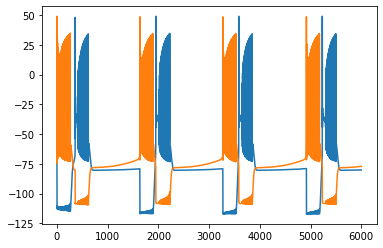

In [93]:
plt.plot(sol.t, sol.y[16])
plt.plot(sol.t, sol.y[0])

In [103]:
#2 neurons
## Simulation of the model in current-clamp mode

## Definition of reversal potential values. 
VNa = 50.; # Sodium reversal potential 45
VCa = 120.; # Calcium reversal potential
VK = -80.; # Potassium reversal potential -90
VH= -43.; # Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
Vleak = -49.; # Reversal potential of leak channels
VSyn=-120.

## Definition of membrane capacitance and maximal conductance values. 
C=0.1; # Membrane capacitance
gLeak=0.1; # Leak current maximal conductance
gNa=120.; # Sodium current maximal conductance
gKd=30.; # Delayed-rectifier potassium current maximal conductance
gA=0.; # A-type potassium current maximal conductance
gKir=0.; # Inward-rectifier potassium current maximal conductance
gT=2.; # T-type calcium current maximal conductance
gH=0.1; # H-current maximal conductance
gL=0.4; # L-type calcium current maximal conductance
gKCa=2.; # Calcium-activated potassium current maximal conductance
gSyn=4. # Synapse maximal conductance
a=2.
b=0.1
## Definition of simulation time.
Tfinal=6000.0
tspan=[0.0,Tfinal]

## Input current defition
# Constant current
Iapp=-4.

# Current pulses
I1=0. # Amplitude of first pulse
ti1=0. # Starting time of first pulse
tf1=100. # Ending time of first pulse
I2=0. # Amplitude of second pulse
ti2=50. # Starting time of second pulse
tf2=150. # Ending time of first pulse

# Sinusoidal input
Ain=0. # Amplitude
Win=0.5 # Frequency

# Input noise
NoiseIN=0.0 # Amplitude
TauNoise=2.0 # Cut-off frequency

#Hyperparameters
gamma=10.
variable_mask=np.array([1,1,1,1,1,1,1,1,1,1,1,1,0])
mask=np.array([1,1,1,1,1,1,1,1,1,1,1,1,0]) #freeze variable by setting 0 in the mask
gamma_mask=variable_mask*gamma
variable_alpha=np.array([1,1,1,1,1,1,1,1,1,1,1,1,0])
alpha=0.01

## Current-clamp experiment
# Parameter vector for simulations
p=[Iapp,2.5,I2,ti1,tf1,ti2,tf2,gT,gKd,gH,gNa,gA,gKir,gLeak,gL,gKCa,gSyn,0.,0.,0.,a,b,C,NoiseIN,TauNoise,Ain,Win]
p1 = List()
[p1.append(x) for x in p]
p=[Iapp,I1,I2,ti1,tf1,ti2,tf2,gT,gKd,gH,gNa,gA,gKir,gLeak,gL,gKCa,gSyn,0.,0.,0.,a,b,C,NoiseIN,TauNoise,Ain,Win]
p2 = List()
[p2.append(x) for x in p]
# Initial conditions
V0= -70.
x0 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), 
      mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), Syn_inf(V0,a,b),Syn_inf(V0,a,b),Syn_inf(V0,a,b),Syn_inf(V0,a,b), 0.0]
V0= -63.
x1 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0),
      mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), Syn_inf(V0,a,b),Syn_inf(V0,a,b),Syn_inf(V0,a,b),Syn_inf(V0,a,b), 0.0]

Theta0= np.random.rand(num_Theta)*100.
Theta0[12:13]=[0.]
#Theta0[7]=0.4
print(Theta0)
A0=(np.ones(num_Theta)*0.1).tolist()*variable_mask
P0=np.diag(np.diag(np.outer(A0,A0))).flatten().tolist()
#P0[-1]=0
X0_=[*x0,*Theta0,*A0,*P0,*x0,*x1,*Theta0,*A0,*P0,*x1]
print(len(X0_))
print(len(Theta0))

[64.15323556  4.92829411 67.96669987 53.28831734  9.09431451 13.77306273
 38.0843115  82.08108369 87.86861002 75.00999156 35.99444816 40.55490172
  0.        ]
454
13


In [104]:
start = time.time()
sol=solve_ivp(HCO_OB ,tspan , X0_)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

Elapsed (with compilation) = 159.4039089679718


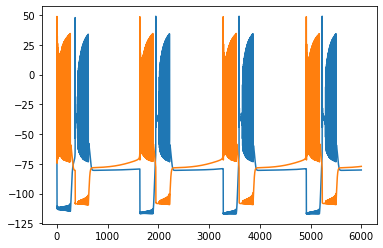

In [105]:
plt.plot(sol.t, sol.y[num_parameter+num_dinamics+num_Theta+num_phi+num_p])
plt.plot(sol.t, sol.y[num_dinamics+num_Theta+num_phi+num_p])

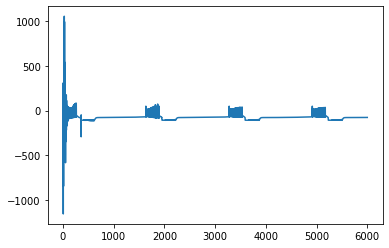

In [106]:
plt.plot(sol.t, sol.y[0])

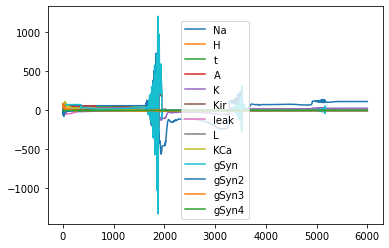

['Na', 'H', 't', 'A', 'K', 'Kir', 'leak', 'L', 'KCa', 'gSyn', 'gSyn2', 'gSyn3', 'gSyn4']
[ 1.14293416e+02  9.75284869e-02  1.78016520e+00 -1.09429449e-01
  2.88311008e+01 -1.52994548e-02  1.07302550e-01  3.81097507e-01
  1.95816656e+00  3.93476595e+00  5.39879395e-03 -4.85706816e-02
  0.00000000e+00]


In [107]:
#plot parameters
labels=[ 'Na','H','t','A','K','Kir','leak','L','KCa','gSyn','gSyn2','gSyn3','gSyn4']
plt.figure()
for i in range(num_Theta):
    plt.plot(sol.t,sol.y[16+i],label=labels[i])
plt.legend()
plt.show()
print(labels)
print(sol.y[16:16+num_Theta,-1])

In [134]:
#Test real model 3 neurons
## Simulation of the model in current-clamp mode

## Definition of reversal potential values. 
VNa = 50.; # Sodium reversal potential 45
VCa = 120.; # Calcium reversal potential
VK = -80.; # Potassium reversal potential -90
VH= -43.; # Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
Vleak = -49.; # Reversal potential of leak channels
VSyn=-120.

## Definition of membrane capacitance and maximal conductance values. 
C=0.1; # Membrane capacitance
gLeak=0.1; # Leak current maximal conductance
gNa=120.; # Sodium current maximal conductance
gKd=30.; # Delayed-rectifier potassium current maximal conductance
gA=0.; # A-type potassium current maximal conductance
gKir=0.; # Inward-rectifier potassium current maximal conductance
gT=2.; # T-type calcium current maximal conductance
gH=0.1; # H-current maximal conductance
gL=0.4; # L-type calcium current maximal conductance
gKCa=2.; # Calcium-activated potassium current maximal conductance
gSyn=4.0
a=2.0
b=0.1
## Definition of simulation time.
Tfinal=6000.0
tspan=[0.0,Tfinal]

## Input current defition
# Constant current
Iapp=-4.0

# Current pulses
I1=0. # Amplitude of first pulse
ti1=0. # Starting time of first pulse
tf1=100.0 # Ending time of first pulse
I2=0. # Amplitude of second pulse
ti2=50.0 # Starting time of second pulse
tf2=150.0 # Ending time of first pulse

# Sinusoidal input
Ain=0.0 # Amplitude
Win=0.5 # Frequency

# Input noise
NoiseIN=0.0 # Amplitude
TauNoise=2.0 # Cut-off frequency


#Hyperparameters
gamma=10.
variable_mask=np.array([1,1,1,1,1,1,1,1,1,1,1,1,1])
mask=np.array([1,1,1,1,1,1,1,1,1,1,1,1,1]) #freeze variable by setting 0 in the mask
gamma_mask=variable_mask*gamma
variable_alpha=np.array([1,1,1,1,1,1,1,1,1,1,1,1,1])
alpha=0.00001

## Current-clamp experiment
# Parameter vector for simulations
p=[Iapp,2.5,I2,ti1,tf1,ti2,tf2,gT,gKd,gH,gNa,gA,gKir,gLeak,gL,gKCa,gSyn,0.,0.,0.,a,b,C,NoiseIN,TauNoise,Ain,Win]
p1 = List()
[p1.append(x) for x in p]
p=[Iapp,I1,I2,ti1,tf1,ti2,tf2,gT,gKd,gH,gNa,gA,gKir,gLeak,gL,gKCa,gSyn,0.,0.,0.,a,b,C,NoiseIN,TauNoise,Ain,Win]
p2 = List()
[p2.append(x) for x in p]
p=[Iapp,I1,I2,ti1,tf1,ti2,tf2,gT,gKd,gH,gNa,gA,gKir,gLeak,gL,gKCa,gSyn,0.,0.,0.,a,b,C,NoiseIN,TauNoise,Ain,Win]
p3 = List()
[p3.append(x) for x in p]
# Initial conditions
V0= -70.
x0 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), 
      mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), Syn_inf(V0,a,b),Syn_inf(V0,a,b),Syn_inf(V0,a,b),Syn_inf(V0,a,b), 0.0]
V0= -63.
x1 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0),
      mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), Syn_inf(V0,a,b),Syn_inf(V0,a,b),Syn_inf(V0,a,b),Syn_inf(V0,a,b), 0.0]
V0= -60.
x2 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0),
      mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), Syn_inf(V0,a,b),Syn_inf(V0,a,b),Syn_inf(V0,a,b),Syn_inf(V0,a,b), 0.0]

V0= -100*np.random.rand(1)
x0_ = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0),
      mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), Syn_inf(V0,a,b),Syn_inf(V0,a,b),Syn_inf(V0,a,b),Syn_inf(V0,a,b), 0.0]
V0= -100*np.random.rand(1)
x1_ = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0),
      mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), Syn_inf(V0,a,b),Syn_inf(V0,a,b),Syn_inf(V0,a,b),Syn_inf(V0,a,b), 0.0]
V0= -100*np.random.rand(1)
x2_ = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0),
      mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), Syn_inf(V0,a,b),Syn_inf(V0,a,b),Syn_inf(V0,a,b),Syn_inf(V0,a,b), 0.0]


Theta0= np.random.rand(num_Theta)*100.
Theta0[11:13]=[0.,0.]
#Theta0[7]=0.4
print(Theta0)
A0=(np.ones(num_Theta)*0.1).tolist()*variable_mask
P0=np.diag(np.diag(np.outer(A0,A0))).flatten().tolist()
#P0[-1]=0
X0_=[*x0_,*Theta0,*A0,*P0,*x0,*x1_,*Theta0,*A0,*P0,*x1,*x2_,*Theta0,*A0,*P0,*x2]
print(len(X0_))
print(len(Theta0))


[99.75464302 54.70784951 45.83293935 95.8741913  82.22038871 27.42932679
 57.66749168 45.85008626 53.69916017 54.04953029 85.41496208  0.
  0.        ]
681
13


In [135]:
start = time.time()
sol=solve_ivp(three_neurons_OB ,tspan , X0_)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

Elapsed (with compilation) = 811.3520250320435


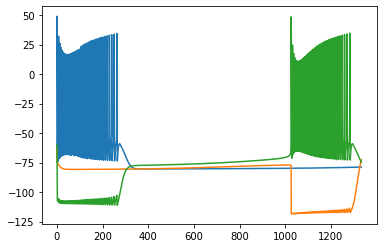

In [122]:
plt.plot(sol.t, sol.y[pos_p])
plt.plot(sol.t, sol.y[num_parameter+pos_p])
plt.plot(sol.t, sol.y[num_parameter*2+pos_p])

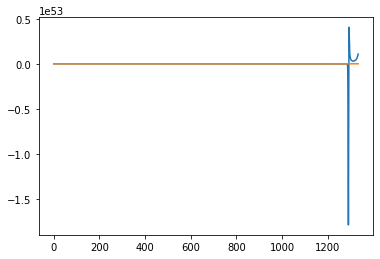

In [123]:
plt.plot(sol.t, sol.y[0])
plt.plot(sol.t, sol.y[pos_p])

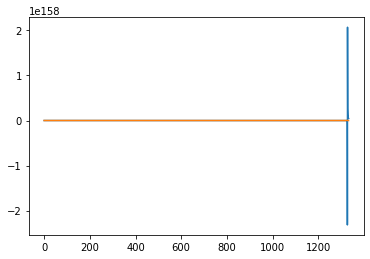

In [124]:
plt.plot(sol.t, sol.y[num_parameter])
plt.plot(sol.t, sol.y[num_parameter+num_dinamics+num_Theta+num_phi+num_p])

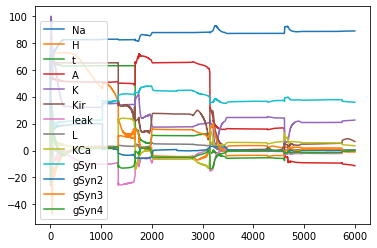

['Na', 'H', 't', 'A', 'K', 'Kir', 'leak', 'L', 'KCa', 'gSyn', 'gSyn2', 'gSyn3', 'gSyn4']
[88.73672012431683 -0.8689470825232672 0.2409445867527965
 -11.289916700710368 22.625998258906115 6.66150064589697
 0.2604185916685371 0.2044255844716766 3.5296567088827424
 35.75443114099625 0.11663654943367965 -1.064077844862136
 -0.03100641029293845]


In [63]:
#plot parameters
labels=[ 'Na','H','t','A','K','Kir','leak','L','KCa','gSyn','gSyn2','gSyn3','gSyn4']
plt.figure()
for i in range(num_Theta):
    plt.plot(sol.t,sol.y[16+i],label=labels[i])
plt.legend()
plt.show()
print(labels)
print(sol.y[16:16+num_Theta,-1])

C:\Users\lenovo\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


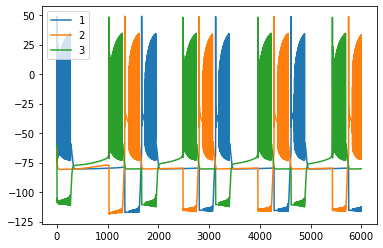

In [443]:
plt.plot(sol.t, sol.y[0],label='1')
plt.plot(sol.t, sol.y[13],label='2')
plt.plot(sol.t, sol.y[26],label='3')
plt.legend()
plt.show()

In [ ]:
#Test real model 5 neurons
## Simulation of the model in current-clamp mode

## Definition of reversal potential values. 
VNa = 50.; # Sodium reversal potential 45
VCa = 120.; # Calcium reversal potential
VK = -80.; # Potassium reversal potential -90
VH= -43.; # Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
Vleak = -49.; # Reversal potential of leak channels
VSyn=-120.

## Definition of membrane capacitance and maximal conductance values. 
C=0.1; # Membrane capacitance
gLeak=0.1; # Leak current maximal conductance
gNa=120.; # Sodium current maximal conductance
gKd=30.; # Delayed-rectifier potassium current maximal conductance
gA=0.; # A-type potassium current maximal conductance
gKir=0.; # Inward-rectifier potassium current maximal conductance
gT=2.; # T-type calcium current maximal conductance
gH=0.1; # H-current maximal conductance
gL=0.4; # L-type calcium current maximal conductance
gKCa=2.; # Calcium-activated potassium current maximal conductance
gSyn=4.0
a=2.0
b=0.1
## Definition of simulation time.
Tfinal=6000.0
tspan=[0.0,Tfinal]

## Input current defition
# Constant current
Iapp=-4.0

# Current pulses
I1=0. # Amplitude of first pulse
ti1=0. # Starting time of first pulse
tf1=100.0 # Ending time of first pulse
I2=0. # Amplitude of second pulse
ti2=50.0 # Starting time of second pulse
tf2=150.0 # Ending time of first pulse

# Sinusoidal input
Ain=0.0 # Amplitude
Win=0.5 # Frequency

# Input noise
NoiseIN=0.0 # Amplitude
TauNoise=2.0 # Cut-off frequency


#Hyperparameters
gamma=10.
variable_mask=np.array([1,1,1,1,1,1,1,1,1,1,1,1,1])
mask=np.array([1,1,1,1,1,1,1,1,1,1,1,1,1]) #freeze variable by setting 0 in the mask
gamma_mask=variable_mask*gamma
variable_alpha=np.array([1,1,1,1,1,1,1,1,1,1,1,1,1])
alpha=0.01

## Current-clamp experiment
# Parameter vector for simulations
p=[Iapp,2.5,I2,ti1,tf1,ti2,tf2,gT,gKd,gH,gNa,gA,gKir,gLeak,gL,gKCa,gSyn,0.,0.,0.,a,b,C,NoiseIN,TauNoise,Ain,Win]
p1 = List()
[p1.append(x) for x in p]
p=[Iapp,I1,I2,ti1,tf1,ti2,tf2,gT,gKd,gH,gNa,gA,gKir,gLeak,gL,gKCa,gSyn,0.,0.,0.,a,b,C,NoiseIN,TauNoise,Ain,Win]
p2 = List()
[p2.append(x) for x in p]
p=[Iapp,I1,I2,ti1,tf1,ti2,tf2,gT,gKd,gH,gNa,gA,gKir,gLeak,gL,gKCa,gSyn,0.,0.,0.,a,b,C,NoiseIN,TauNoise,Ain,Win]
p3 = List()
[p3.append(x) for x in p]
p4 = List()
[p4.append(x) for x in p]
p5 = List()
[p5.append(x) for x in p]
# Initial conditions
V0= -70.
x0 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), 
      mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), Syn_inf(V0,a,b),Syn_inf(V0,a,b),Syn_inf(V0,a,b),Syn_inf(V0,a,b), 0.0]
V0= -63.
x1 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0),
      mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), Syn_inf(V0,a,b),Syn_inf(V0,a,b),Syn_inf(V0,a,b),Syn_inf(V0,a,b), 0.0]
V0= -60.
x2 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0),
      mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), Syn_inf(V0,a,b),Syn_inf(V0,a,b),Syn_inf(V0,a,b),Syn_inf(V0,a,b), 0.0]
V0= -70.
x3 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), 
      mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), Syn_inf(V0,a,b),Syn_inf(V0,a,b),Syn_inf(V0,a,b),Syn_inf(V0,a,b), 0.0]
V0= -63.
x4 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0),
      mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), Syn_inf(V0,a,b),Syn_inf(V0,a,b),Syn_inf(V0,a,b),Syn_inf(V0,a,b), 0.0]


V0= -100*np.random.rand(1)
x0_ = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0),
      mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), Syn_inf(V0,a,b),Syn_inf(V0,a,b),Syn_inf(V0,a,b),Syn_inf(V0,a,b), 0.0]
V0= -100*np.random.rand(1)
x1_ = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0),
      mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), Syn_inf(V0,a,b),Syn_inf(V0,a,b),Syn_inf(V0,a,b),Syn_inf(V0,a,b), 0.0]
V0= -100*np.random.rand(1)
x2_ = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0),
      mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), Syn_inf(V0,a,b),Syn_inf(V0,a,b),Syn_inf(V0,a,b),Syn_inf(V0,a,b), 0.0]
V0= -100*np.random.rand(1)
x3_ = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0),
      mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), Syn_inf(V0,a,b),Syn_inf(V0,a,b),Syn_inf(V0,a,b),Syn_inf(V0,a,b), 0.0]
V0= -100*np.random.rand(1)
x4_ = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0),
      mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), Syn_inf(V0,a,b),Syn_inf(V0,a,b),Syn_inf(V0,a,b),Syn_inf(V0,a,b), 0.0]



Theta0= np.random.rand(num_Theta)*100.
Theta0[11:13]=[0.,0.]
#Theta0[7]=0.4
print(Theta0)
A0=(np.ones(num_Theta)*0.1).tolist()*variable_mask
P0=np.diag(np.diag(np.outer(A0,A0))).flatten().tolist()
#P0[-1]=0
X0_=[*x0_,*Theta0,*A0,*P0,*x0,*x1_,*Theta0,*A0,*P0,*x1,
     *x2_,*Theta0,*A0,*P0,*x2,
     *x3_,*Theta0,*A0,*P0,*x3,
     *x4_,*Theta0,*A0,*P0,*x4]
print(len(X0_))
print(len(Theta0))